# 基于数据特点划分新的几种类别

预期：平稳型、正U型、倒U型、递增型、递减型  
  
实际：  
四类：递减型、递增型、倒U型、正U型  
五类：递减型、递增型、倒U型、正U型、正U型（10左右）  
六类：递减型、递增型、倒U型、正U型、正U型（10左右）、正U型（10以上）  

可以采取的思路：图形相似度、时间序列相似度、找合适的分类模型、按照图形进行非监督分类  

实际采取的思路：sklearn-kmeans

# 点信息汇总

包括样本点的坐标、RGB波段值、土地利用类型以及农作物类型

## 区域统计 $\color{red}{arcpy}$

In [10]:
import os
import arcpy
from arcpy import env
from arcpy.sa import *

workspace_list = [r"F:\Data\Extension_Research\Multitemporal_Research_CN\Landcover\cn_reclass",
                 r"F:\Data\Extension_Research\Multitemporal_Research_CN\Composition",
                 r'F:\Data\Extension_Research\Multitemporal_Research_CN\CropType\croptype_three']
output_path = r"F:\Data\Extension_Research\Multitemporal_Research_CN\RandomPoints\zonal_stats"
shp_path = r"F:\Data\Extension_Research\Multitemporal_Research_CN\RandomPoints\shp\RandomPoints.shp"

zoneField = "FID"
for workspace in workspace_list:
    datanames = os.listdir(workspace)
    output = output_path
    shp = shp_path

    count = 0
    for dataname in datanames:
        if os.path.splitext(dataname)[1] == '.tif':
            count = count + 1
            print(dataname)
    print('count:' + str(count))

    num = 1
    for dataname in datanames:
        if os.path.splitext(dataname)[1] == '.tif':
            data_name = os.path.splitext(dataname)[0]
            arcpy.CheckOutExtension("Spatial")

            file_name = data_name.split('.')[0]
            raster = workspace + "/" + dataname
            outTable = (output + "/" + file_name + ".dbf")
            print(outTable)
            outZSaT = ZonalStatisticsAsTable(shp, zoneField, raster, outTable, "DATA", "ALL")

            print(1.0 * num / count)
            num = num + 1
print('finish')

MCD12Q1_cn_reclass.tif
count:1
F:\Data\Extension_Research\Multitemporal_Research_CN\SamplePoints\zonal_stats/MCD12Q1_cn_reclass.dbf
1.0
DVNL_2013.tif
F152013_intercal.tif
F182013.v4c.global.intercal.stable_lights.avg_vis.tif
count:3
F:\Data\Extension_Research\Multitemporal_Research_CN\SamplePoints\zonal_stats/DVNL_2013.dbf
0.3333333333333333
F:\Data\Extension_Research\Multitemporal_Research_CN\SamplePoints\zonal_stats/F152013_intercal.dbf
0.6666666666666666
F:\Data\Extension_Research\Multitemporal_Research_CN\SamplePoints\zonal_stats/F182013.dbf
1.0
crop_three.tif
count:1
F:\Data\Extension_Research\Multitemporal_Research_CN\SamplePoints\zonal_stats/crop_three.dbf
1.0
finish


## 读取随机点并汇总信息

作物类型：1-旱地，2-水地  
用地类型：1-水体，2-林地，3-草地，4-农田与自然交界，5-农田，6-城市与建成区，7-贫瘠地

In [117]:
# -*- coding:utf-8 -*- 

import os
import pandas as pd
from dbfread import DBF
import numpy as np

dbf_path = r'F:\Data\Extension_Research\Multitemporal_Research_CN\RandomPoints\zonal_stats'
xy_path = r'F:\Data\Extension_Research\Multitemporal_Research_CN\RandomPoints\shp\RandomPoints.xls'
output_path = r'F:\Data\Extension_Research\Multitemporal_Research_CN\RandomPoints\info\info.xlsx'

file_name = os.listdir(dbf_path)
dbf_name = []
for name in file_name:
    if name[-4:] == '.dbf':
        dbf_name.append(name)
df = pd.DataFrame({'FID_':list(range(0,30000))})
for name in dbf_name:
    dbf = os.path.join(dbf_path, name)
    data = pd.DataFrame(iter(DBF(dbf, encoding='GBK')))
    data = data[['FID_','MIN']]
    df = pd.merge(df, data, on='FID_')
df.columns = ['ID', 'crop_type', 'G', 'B', 'R','Landcover']
df = df[['ID', 'crop_type', 'R', 'G', 'B','Landcover']]

xy_df = pd.read_excel(xy_path, usecols=[0,2,3])
# xy_df.colums = ['ID','Longitude','Latitude']
xy_df.columns = ['ID','Longtitude','Latitude']
df = pd.merge(df, xy_df, on='ID')

index_list = []
for index, row in df.iterrows():
    if row['R'] == row['G'] == row['B'] == 0:
        index_list.append(index)
df = df.drop(index_list)
df = df.reset_index() # 重置index

df.to_excel(output_path)
df

,index,ID,crop_type,R,G,B,Landcover,Longtitude,Latitude
0,3,3,0,5.949059,0.0,0.000000,3,125.769300,45.648026
1,5,5,0,8.860242,4.0,5.741766,2,113.683949,23.547036
2,16,16,0,7.901553,4.0,6.840661,5,109.626856,23.004622
3,17,17,0,54.629761,54.0,53.861397,6,114.284700,22.673125
4,22,22,0,50.941750,32.0,53.589664,3,125.243917,46.512995
...,...,...,...,...,...,...,...,...,...
3906,19943,19977,0,15.299281,5.0,10.427002,5,114.720659,30.771654
3907,19947,19981,1,5.917341,0.0,5.412887,5,116.901021,37.501477
3908,19951,19985,0,6.557189,4.0,6.059938,2,121.281558,29.181877
3909,19955,19989,1,11.457967,5.0,7.875866,5,115.748009,38.464578


# 数据类别划分

## sklearn - kmeans调用

CSDN:  
[sklearn—kmeans参数、及案例（数据+代码+结果）](https://blog.csdn.net/Monk_donot_know/article/details/86681938?spm=1001.2101.3001.6661.1&utm_medium=distribute.pc_relevant_t0.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1-86681938-blog-85159661.pc_relevant_multi_platform_whitelistv2&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1-86681938-blog-85159661.pc_relevant_multi_platform_whitelistv2&utm_relevant_index=1)  
[Sklearn之KMeans算法](https://blog.csdn.net/guihenao4010/article/details/85159661)

### 分类情况判断

#### 轮廓系数

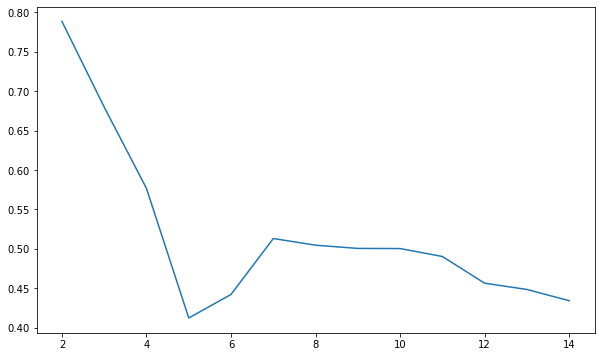

In [147]:
# -*- coding:utf-8 -*- 
# 轮廓系数图像斜率越大说明对应分类越合适

data = pd.read_excel(r'F:\Data\Extension_Research\Multitemporal_Research_CN\RandomPoints\info\info.xlsx')
data = data[['R','G','B']]

# index_list_2 = []
# for index, row in data.iterrows():
#     if row['R'] > 16:
#         index_list_2.append(index)
#     elif row['G'] > 16:
#         index_list_2.append(index)
#     elif row['B'] > 16:
#         index_list_2.append(index)
# data = data.drop(index_list_2)
# data = np.array(data)

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
silhouettescore=[]
for i in range(2,15):
    kmeans=KMeans(n_clusters=i,random_state=123).fit(data)
    score=silhouette_score(data,kmeans.labels_)
    silhouettescore.append(score)
plt.figure(figsize=(10,6))
plt.plot(range(2,15),silhouettescore,linewidth=1.5,linestyle='-')
plt.show()

#### Calinski-Harabasz指数评价

In [148]:
# -*- coding:utf-8 -*- 
# 指数越大分类效果越好

data = pd.read_excel(r'F:\Data\Extension_Research\Multitemporal_Research_CN\RandomPoints\info\info.xlsx')
data = data[['R','G','B']]

# index_list_2 = []
# for index, row in data.iterrows():
#     if row['R'] > 10:
#         index_list_2.append(index)
#     elif row['G'] > 10:
#         index_list_2.append(index)
#     elif row['B'] > 10:
#         index_list_2.append(index)
# data = data.drop(index_list_2)
# data = np.array(data)

from sklearn.metrics import calinski_harabasz_score
for i in range(2,10):
    kmeans=KMeans(n_clusters=i,random_state=123).fit(data)
    score=calinski_harabasz_score(data,kmeans.labels_)
    print("聚类%d簇的calinski_harabaz分数为：%f" %(i,score))

聚类2簇的calinski_harabaz分数为：10976.152393
聚类3簇的calinski_harabaz分数为：12008.751489
聚类4簇的calinski_harabaz分数为：12463.908640
聚类5簇的calinski_harabaz分数为：12395.852905
聚类6簇的calinski_harabaz分数为：12548.122905
聚类7簇的calinski_harabaz分数为：12202.001003
聚类8簇的calinski_harabaz分数为：12293.718571
聚类9簇的calinski_harabaz分数为：12385.786621


### 具体分类

4类（10以下）：递减、正U、倒U、递增  
5类（16以下）：正U、递减、大正U、递增、倒U  
6类（21以下）：倒U、小正U（10以下）、递减、正U、递增、大正U（10以上）

[[ 5.94905949  0.          0.        ]
 [ 8.86024189  4.          5.74176645]
 [ 7.90155315  4.          6.84066057]
 ...
 [ 6.55718899  4.          6.05993795]
 [11.4579668   5.          7.87586594]
 [ 7.888412    1.          5.99937868]]
(3243, 3)
<class 'numpy.ndarray'>
[1]
              R          G             B  类别数目
0 -1.776357e-15   1.963636 -2.664535e-15   165
1  7.344454e+00   2.690343  6.312365e+00  1251
2  6.559686e+00   0.778489  0.000000e+00   781
3  1.192457e+01   5.533210  9.258399e+00   544
4 -2.664535e-15   1.292254  5.859154e+00   284
5  1.727199e+01  10.036697  1.450390e+01   218


F:\Python\Anaconda\anaconda\envs\edmsp\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


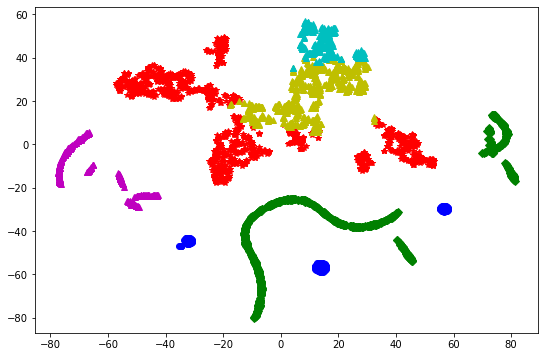

[[-1.77635684e-15  1.96363636e+00 -2.66453526e-15]
 [ 7.34445378e+00  2.69034318e+00  6.31236454e+00]
 [ 6.55968603e+00  7.78489117e-01  0.00000000e+00]
 [ 1.19245695e+01  5.53321033e+00  9.25839936e+00]
 [-2.66453526e-15  1.29225352e+00  5.85915382e+00]
 [ 1.72719895e+01  1.00366972e+01  1.45038989e+01]]


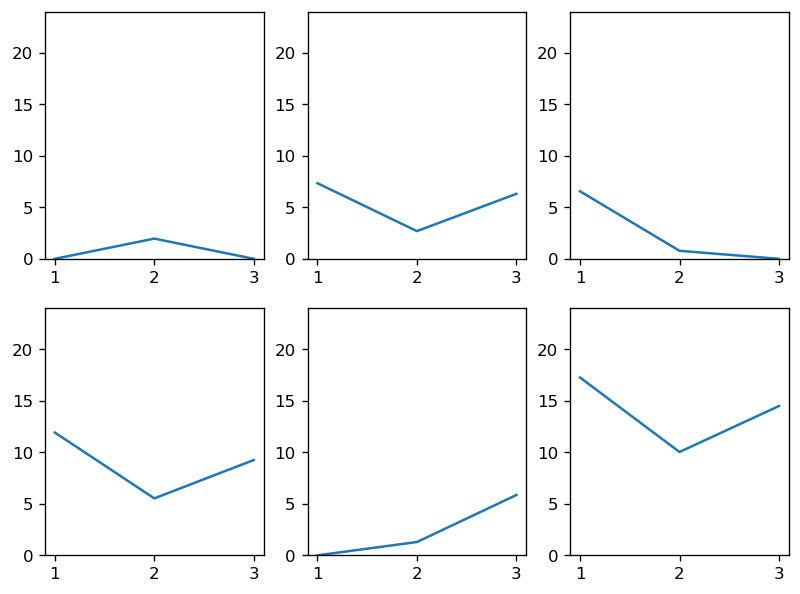

[2 1 1 ... 1 3 1]
      类别数目
0        2
1        1
2        1
3        1
4        1
...    ...
3238     3
3239     1
3240     1
3241     3
3242     1

[3243 rows x 1 columns]
      level_0  Unnamed: 0  index     ID  crop_type          R  G          B  \
0           0           0      3      3          0   5.949059  0   0.000000   
1           1           1      5      5          0   8.860242  4   5.741766   
2           2           2     16     16          0   7.901553  4   6.840661   
3           5           5     30     30          0   6.599327  0   5.672522   
4           7           7     39     39          0   7.769519  4   6.986756   
...       ...         ...    ...    ...        ...        ... ..        ...   
3238     3906        3906  19943  19977          0  15.299281  5  10.427002   
3239     3907        3907  19947  19981          1   5.917341  0   5.412887   
3240     3908        3908  19951  19985          0   6.557189  4   6.059938   
3241     3909        3909  19955  1

,level_0,Unnamed: 0,index,ID,crop_type,R,G,B,Landcover,Longtitude,Latitude,类别数目
0,0,0,3,3,0,5.949059,0,0.000000,3,125.769300,45.648026,2
1,1,1,5,5,0,8.860242,4,5.741766,2,113.683949,23.547036,1
2,2,2,16,16,0,7.901553,4,6.840661,5,109.626856,23.004622,1
3,5,5,30,30,0,6.599327,0,5.672522,5,115.184156,36.629286,1
4,7,7,39,39,0,7.769519,4,6.986756,3,127.133425,45.586157,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3238,3906,3906,19943,19977,0,15.299281,5,10.427002,5,114.720659,30.771654,3
3239,3907,3907,19947,19981,1,5.917341,0,5.412887,5,116.901021,37.501477,1
3240,3908,3908,19951,19985,0,6.557189,4,6.059938,2,121.281558,29.181877,1
3241,3909,3909,19955,19989,1,11.457967,5,7.875866,5,115.748009,38.464578,3


In [9]:
# -*- coding:utf-8 -*- 
# 修改类别数：1、修改阈值；2、修改KMEANS参数；3、修改label数以及呈现形式；4、修改类别数据特点plot循环次数

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# import warning
# warnings.filterwarnings("ignore")

data = pd.read_excel(r'F:\Data\Extension_Research\Multitemporal_Research_CN\RandomPoints\info\info.xlsx')
data = data[['R','G','B']]

# 4类阈值10，5类阈值16，6类阈值21
index_list_2 = []
for index, row in data.iterrows():
    if row['R'] > 21:
        index_list_2.append(index)
    elif row['G'] > 21:
        index_list_2.append(index)
    elif row['B'] > 21:
        index_list_2.append(index)
data = data.drop(index_list_2)
data = np.array(data)

print(data)
print(data.shape)
print(type(data))

# Z分数标准化标准化
data_zs=(data-data.mean())/data.std()
# 也可以自定义函数minmax标准化、这里采用现成的函数
scale=MinMaxScaler().fit(data)
datascale=scale.transform(data)

# n_clusters设置聚类类别数，当前已确定4、5、6的情况
kmeans=KMeans(n_clusters=6,random_state=123).fit(data)
result=kmeans.predict([[5.6,2.8,4.9]])
# 预测的数据需要使用和训练数据同样的标准化
print(result)

# 简要打印结果
r1=pd.Series(kmeans.labels_).value_counts()
r2=pd.DataFrame(kmeans.cluster_centers_)
r=pd.concat([r2,r1],axis=1)
r.columns=['R','G','B']+[u'类别数目']
print(r)

# n_components=2，即以二维的形式呈现
tsne=TSNE(n_components=2,init='random',random_state=177).fit(data)
df=pd.DataFrame(tsne.embedding_)
df['labels']=kmeans.labels_
# 类别数是多少就保留多少label
df1=df[df['labels']==0]
df2=df[df['labels']==1]
df3=df[df['labels']==2]
df4=df[df['labels']==3]
df5=df[df['labels']==4]
df6=df[df['labels']==5]
fig=plt.figure(figsize=(9,6))
# 依类别数确定要呈现的颜色和形状
## 目前已知可用颜色有b r g y m c，已知可用的形状有o * D ^ 
# plt.plot(df1[0],df1[1],'bo',df2[0],df2[1],'r*',df3[0],df3[1],'gD',df4[0],df4[1],'y*',df5[0],df5[1],'m^')
plt.plot(df1[0],df1[1],'bo',df2[0],df2[1],'r*',df3[0],df3[1],'gD',df4[0],df4[1],'y^',df5[0],df5[1],'m^',df6[0],df6[1],'c^')
plt.show()

print(kmeans.cluster_centers_)
x = [1,2,3]
y = kmeans.cluster_centers_
fig = plt.figure(figsize=(8, 6), dpi=120)
# 依类别数确定循环次数和子图布局
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(x,y[i])
    plt.ylim(0,24)
plt.show()

print(kmeans.predict(data))

#详细输出原结果
all_result = pd.concat([pd.DataFrame(data),pd.Series(kmeans.labels_)],axis=1)
all_result.columns = ['R','G','B'] + [u'类别数目']
all_result = all_result[['类别数目']]
print(all_result)

raw_data_path = r'F:\Data\Extension_Research\Multitemporal_Research_CN\RandomPoints\info\info.xlsx'
raw_data = pd.read_excel(raw_data_path)
raw_data = raw_data.drop(index_list_2)
raw_data = raw_data.reset_index() # 重置index
print(raw_data)

# 分类结果与原始数据合并
final_result = pd.concat([raw_data, all_result],axis=1)
# final_result.to_csv(
#     r"F:\Data\Extension_Research\Multitemporal_Research_CN\Classification\sklearn_kmeans_RP_6_21\sklearn_kmeans_result.csv")
final_result

## KNN&DTW 按照时间序列分类

Github  
https://github.com/alexminnaar/time-series-classification-and-clustering  
https://github.com/vvanggeng/TSC-KNN

# 数据分布情况

## 热力图 ArcMap

相关资料：  
[知乎 - ArcGIS核密度分析](https://zhuanlan.zhihu.com/p/358708257)  
[知乎 - 如何使用ArcGIS制作热力图](https://zhuanlan.zhihu.com/p/101035211)

处理流程：  
1、由xlsx表格文件导出dbf，再由dbf文件显示XY数据；  
2、按照属性值划分：Analysis Tool - Extract - Split By Attributes，得到独立属性点数据，存放在“.\Split”文件夹；  
3、热力图：Spatial Analyst Tools - Density - Kernel Desity，得到热力tiff，存放在“.\KernelDensity”文件夹；  
4、加入绘图基础数据、图例、指北针、比例尺，在同一布局视图、同一分类标准（以4类递减情况为准）下，导出地图，存放在“.\map”文件夹；  

## 按照分区数据统计各类占比

统计区域内点个数：Analysis Tools - Overlay - Spatial Join  
生成的shp文件，属性表中有join_count字段

### 行政区划（省市县三级）

pandas判断几列中最大值对应的列索引：[python利用pandas获取每行数据的最大值，最小值以及对应的columns](https://blog.csdn.net/Anneaisun1995/article/details/103640112)

In [1]:
# -*- coding:utf-8 -*-
# 可识别类别和范围的整合版

import os
import pandas as pd
from dbfread import DBF
import warnings
warnings.filterwarnings("ignore")

# dbf所在文件夹（shp文件路径）和csv输出路径的设置
dbf_path = r'F:\Data\Extension_Research\Multitemporal_Research_CN\Classification\sklearn_kmeans_RP_6_21\CountRate\SpatialJoin_county'
csv_path = r'F:\Data\Extension_Research\Multitemporal_Research_CN\Classification\sklearn_kmeans_RP_6_21\CountRate\CR_6212.csv'

# 确定分类数以及研究尺度
file_name = os.listdir(dbf_path)
dbf_name = []
for name in file_name:
    if name[-4:] == '.dbf':
        dbf_name.append(name)
df = pd.DataFrame({'TARGET_FID':list(range(0,3000))})
print('分类数：', dbf_name[0][3])
print('研究尺度：',dbf_path[113:])

# 根据类别数和研究区域整合DataFrame数据
if dbf_name[0][3] == '4':
    if dbf_path[113:] == 'province':
        for name in dbf_name:
            dbf = os.path.join(dbf_path, name)
            data = pd.DataFrame(iter(DBF(dbf, encoding='utf-8')))
            data = data[['Join_Count','TARGET_FID','省']]
            df = pd.merge(df, data, on='TARGET_FID')

        df.columns = ['ID', '0','Province','1','省','2','省','3','省']
        df = df[['ID', '0', '1', '2', '3','Province']]
        # 计算并以新列并入dataframe
        df['rate0'] = df[['0','1','2','3']].apply(lambda x:x['0']/(x['0']+x['1']+x['2']+x['3']),axis=1)
        df['rate1'] = df[['0','1','2','3']].apply(lambda x:x['1']/(x['0']+x['1']+x['2']+x['3']),axis=1)
        df['rate2'] = df[['0','1','2','3']].apply(lambda x:x['2']/(x['0']+x['1']+x['2']+x['3']),axis=1)
        df['rate3'] = df[['0','1','2','3']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']),axis=1)
        df['rate0'] = df['rate0'].apply(lambda x: format(x, '.2%'))
        df['rate1'] = df['rate1'].apply(lambda x: format(x, '.2%'))
        df['rate2'] = df['rate2'].apply(lambda x: format(x, '.2%'))
        df['rate3'] = df['rate3'].apply(lambda x: format(x, '.2%'))

        df.columns = [  'ID','递减型点数','正U型点数','倒U型点数','递增型点数',
                      '省份','递减型比率','正U型比率','倒U型比率','递增型比率']
        df = df[['ID','省份','递减型点数','递增型点数','倒U型点数','正U型点数',
                             '递减型比率','递增型比率','倒U型比率','正U型比率']]

        # 对比找到各个数据特点对应的数据占比，确定最大值对应的类型，新建一列存放信息
        df_max = df[['递减型点数','递增型点数','倒U型点数','正U型点数']]
        df_max.columns = ['1','2','3','4']
        df_max['max_idx'] = df_max.idxmax(axis=1) #求一行的最大值对应的索引
        df_max['max_val']= df_max.max(axis=1) #取出该最大值
        df_max_idx_val = df_max[['max_idx','max_val']]
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_max_idx_val)],axis=1)

        # 对比确定没有数据的情况，确保没有数据的地区显示为空，新建一列存放信息
        df_zero = df[['递减型点数','递增型点数','倒U型点数','正U型点数']]
        df_zero.columns = ['dj','dz','du','zu']
        def if_zero(a,b,c,d):
            if a==b==c==d==0:
                return 1
            else:
                return 0
        df_zero['if_zero'] = df_zero.apply(lambda x: if_zero(x.dj,x.dz,x.du,x.zu), axis=1)
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_zero)],axis=1)
        df = df[['ID','省份','递减型点数','递增型点数','倒U型点数','正U型点数',
                             '递减型比率','递增型比率','倒U型比率','正U型比率','max_idx','max_val','if_zero']]
    elif dbf_path[113:] == 'city':
        for name in dbf_name:
            dbf = os.path.join(dbf_path, name)
            data = pd.DataFrame(iter(DBF(dbf, encoding='utf-8')))
            data = data[['Join_Count','TARGET_FID','省','市']]
            df = pd.merge(df, data, on='TARGET_FID')

        df.columns = ['ID', '0','Province','city','1','省','市','2','省','市','3','省','市']
        df = df[['ID', '0', '1', '2', '3','Province','city']]
        # 计算并以新列并入dataframe
        df['rate0'] = df[['0','1','2','3']].apply(lambda x:x['0']/(x['0']+x['1']+x['2']+x['3']),axis=1)
        df['rate1'] = df[['0','1','2','3']].apply(lambda x:x['1']/(x['0']+x['1']+x['2']+x['3']),axis=1)
        df['rate2'] = df[['0','1','2','3']].apply(lambda x:x['2']/(x['0']+x['1']+x['2']+x['3']),axis=1)
        df['rate3'] = df[['0','1','2','3']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']),axis=1)
        df['rate0'] = df['rate0'].apply(lambda x: format(x, '.2%'))
        df['rate1'] = df['rate1'].apply(lambda x: format(x, '.2%'))
        df['rate2'] = df['rate2'].apply(lambda x: format(x, '.2%'))
        df['rate3'] = df['rate3'].apply(lambda x: format(x, '.2%'))

        df.columns = [       'ID','递减型点数','正U型点数','倒U型点数','递增型点数',
                      '省份','市','递减型比率','正U型比率','倒U型比率','递增型比率']
        df = df[['ID','省份','市','递减型点数','递增型点数','倒U型点数','正U型点数',
                                  '递减型比率','递增型比率','倒U型比率','正U型比率']]

        # 对比找到各个数据特点对应的数据占比，确定最大值对应的类型，新建一列存放信息
        df_max = df[['递减型点数','递增型点数','倒U型点数','正U型点数']]
        df_max.columns = ['1','2','3','4']
        df_max['max_idx'] = df_max.idxmax(axis=1) #求一行的最大值对应的索引
        df_max['max_val']= df_max.max(axis=1) #取出该最大值
        df_max_idx_val = df_max[['max_idx','max_val']]
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_max_idx_val)],axis=1)

        # 对比确定没有数据的情况，确保没有数据的地区显示为空，新建一列存放信息
        df_zero = df[['递减型点数','递增型点数','倒U型点数','正U型点数']]
        df_zero.columns = ['dj','dz','du','zu']
        def if_zero(a,b,c,d):
            if a==b==c==d==0:
                return 1
            else:
                return 0
        df_zero['if_zero'] = df_zero.apply(lambda x: if_zero(x.dj,x.dz,x.du,x.zu), axis=1)
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_zero)],axis=1)
        df = df[['ID','省份','市','递减型点数','递增型点数','倒U型点数','正U型点数',
                                  '递减型比率','递增型比率','倒U型比率','正U型比率','max_idx','max_val','if_zero']]
    elif dbf_path[113:] == 'county':
        for name in dbf_name:
            dbf = os.path.join(dbf_path, name)
            data = pd.DataFrame(iter(DBF(dbf, encoding='utf-8')))
            data = data[['Join_Count','TARGET_FID','省','市','县']]
            df = pd.merge(df, data, on='TARGET_FID')

        df.columns = ['ID', '0','Province','city','county','1','省','市','县','2','省','市','县','3','省','市','县']
        df = df[['ID', '0', '1', '2', '3','Province','city','county']]
        # 计算并以新列并入dataframe
        df['rate0'] = df[['0','1','2','3']].apply(lambda x:x['0']/(x['0']+x['1']+x['2']+x['3']),axis=1)
        df['rate1'] = df[['0','1','2','3']].apply(lambda x:x['1']/(x['0']+x['1']+x['2']+x['3']),axis=1)
        df['rate2'] = df[['0','1','2','3']].apply(lambda x:x['2']/(x['0']+x['1']+x['2']+x['3']),axis=1)
        df['rate3'] = df[['0','1','2','3']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']),axis=1)
        df['rate0'] = df['rate0'].apply(lambda x: format(x, '.2%'))
        df['rate1'] = df['rate1'].apply(lambda x: format(x, '.2%'))
        df['rate2'] = df['rate2'].apply(lambda x: format(x, '.2%'))
        df['rate3'] = df['rate3'].apply(lambda x: format(x, '.2%'))

        df.columns = [       'ID','递减型点数','正U型点数','倒U型点数','递增型点数',
                      '省份','市','县','递减型比率','正U型比率','倒U型比率','递增型比率']
        df = df[['ID','省份','市','县','递减型点数','递增型点数','倒U型点数','正U型点数',
                                  '递减型比率','递增型比率','倒U型比率','正U型比率']]

        # 对比找到各个数据特点对应的数据占比，确定最大值对应的类型，新建一列存放信息
        df_max = df[['递减型点数','递增型点数','倒U型点数','正U型点数']]
        df_max.columns = ['1','2','3','4']
        df_max['max_idx'] = df_max.idxmax(axis=1) #求一行的最大值对应的索引
        df_max['max_val']= df_max.max(axis=1) #取出该最大值
        df_max_idx_val = df_max[['max_idx','max_val']]
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_max_idx_val)],axis=1)

        # 对比确定没有数据的情况，确保没有数据的地区显示为空，新建一列存放信息
        df_zero = df[['递减型点数','递增型点数','倒U型点数','正U型点数']]
        df_zero.columns = ['dj','dz','du','zu']
        def if_zero(a,b,c,d):
            if a==b==c==d==0:
                return 1
            else:
                return 0
        df_zero['if_zero'] = df_zero.apply(lambda x: if_zero(x.dj,x.dz,x.du,x.zu), axis=1)
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_zero)],axis=1)
        df = df[['ID','省份','市','县','递减型点数','递增型点数','倒U型点数','正U型点数',
                                  '递减型比率','递增型比率','倒U型比率','正U型比率','max_idx','max_val','if_zero']]
elif dbf_name[0][3] == '5':
    if dbf_path[113:] == 'province':
        for name in dbf_name:
            dbf = os.path.join(dbf_path, name)
            data = pd.DataFrame(iter(DBF(dbf, encoding='utf-8')))
            data = data[['Join_Count','TARGET_FID','省']]
            df = pd.merge(df, data, on='TARGET_FID')

        df.columns = ['ID', '0','Province', '1','省', '2','省','3','省','4','省']
        df = df[['ID', '0', '1', '2', '3','4','Province']]
        # 计算并以新列并入dataframe
        df['rate0'] = df[['0','1','2','3','4']].apply(lambda x:x['0']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate1'] = df[['0','1','2','3','4']].apply(lambda x:x['1']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate2'] = df[['0','1','2','3','4']].apply(lambda x:x['2']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate3'] = df[['0','1','2','3','4']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate4'] = df[['0','1','2','3','4']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate0'] = df['rate0'].apply(lambda x: format(x, '.2%'))
        df['rate1'] = df['rate1'].apply(lambda x: format(x, '.2%'))
        df['rate2'] = df['rate2'].apply(lambda x: format(x, '.2%'))
        df['rate3'] = df['rate3'].apply(lambda x: format(x, '.2%'))
        df['rate4'] = df['rate4'].apply(lambda x: format(x, '.2%'))

        df.columns = [  'ID','正U型点数','递减型点数','正U型（10左右）点数','递增型点数','倒U型点数',
                      '省份','正U型比率','递减型比率','正U型（10左右）比率','递增型比率','倒U型比率']
        df = df[['ID','省份','递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数',
                             '递减型比率','递增型比率','倒U型比率','正U型比率','正U型（10左右）比率']]

        # 对比找到各个数据特点对应的数据占比，确定最大值对应的类型，新建一列存放信息
        df_max = df[['递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数']]
        df_max.columns = ['1','2','3','4','5']
        df_max['max_idx'] = df_max.idxmax(axis=1) #求一行的最大值对应的索引
        df_max['max_val']= df_max.max(axis=1) #取出该最大值
        df_max_idx_val = df_max[['max_idx','max_val']]
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_max_idx_val)],axis=1)

        # 对比确定没有数据的情况，确保没有数据的地区显示为空，新建一列存放信息
        df_zero = df[['递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数']]
        df_zero.columns = ['dj','dz','du','zu','zu10']
        def if_zero(a,b,c,d,e):
            if a==b==c==d==e==0:
                return 1
            else:
                return 0
        df_zero['if_zero'] = df_zero.apply(lambda x: if_zero(x.dj,x.dz,x.du,x.zu,x.zu10), axis=1)
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_zero)],axis=1)
        df = df[['ID','省份','递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数',
                             '递减型比率','递增型比率','倒U型比率','正U型比率','正U型（10左右）比率','max_idx','max_val','if_zero']]
    elif dbf_path[113:] == 'city':
        for name in dbf_name:
            dbf = os.path.join(dbf_path, name)
            data = pd.DataFrame(iter(DBF(dbf, encoding='utf-8')))
            data = data[['Join_Count','TARGET_FID','省','市']]
            df = pd.merge(df, data, on='TARGET_FID')

        df.columns = ['ID', '0','Province','city','1','省','市','2','省','市','3','省','市','4','省','市']
        df = df[['ID', '0', '1', '2', '3','4','Province','city']]
        # 计算并以新列并入dataframe
        df['rate0'] = df[['0','1','2','3','4']].apply(lambda x:x['0']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate1'] = df[['0','1','2','3','4']].apply(lambda x:x['1']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate2'] = df[['0','1','2','3','4']].apply(lambda x:x['2']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate3'] = df[['0','1','2','3','4']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate4'] = df[['0','1','2','3','4']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate0'] = df['rate0'].apply(lambda x: format(x, '.2%'))
        df['rate1'] = df['rate1'].apply(lambda x: format(x, '.2%'))
        df['rate2'] = df['rate2'].apply(lambda x: format(x, '.2%'))
        df['rate3'] = df['rate3'].apply(lambda x: format(x, '.2%'))
        df['rate4'] = df['rate4'].apply(lambda x: format(x, '.2%'))

        df.columns = [  'ID','正U型点数','递减型点数','正U型（10左右）点数','递增型点数','倒U型点数',
                      '省份','市','正U型比率','递减型比率','正U型（10左右）比率','递增型比率','倒U型比率']
        df = df[['ID','省份','市','递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数',
                             '递减型比率','递增型比率','倒U型比率','正U型比率','正U型（10左右）比率']]

        # 对比找到各个数据特点对应的数据占比，确定最大值对应的类型，新建一列存放信息
        df_max = df[['递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数']]
        df_max.columns = ['1','2','3','4','5']
        df_max['max_idx'] = df_max.idxmax(axis=1) #求一行的最大值对应的索引
        df_max['max_val']= df_max.max(axis=1) #取出该最大值
        df_max_idx_val = df_max[['max_idx','max_val']]
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_max_idx_val)],axis=1)

        # 对比确定没有数据的情况，确保没有数据的地区显示为空，新建一列存放信息
        df_zero = df[['递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数']]
        df_zero.columns = ['dj','dz','du','zu','zu10']
        def if_zero(a,b,c,d,e):
            if a==b==c==d==e==0:
                return 1
            else:
                return 0
        df_zero['if_zero'] = df_zero.apply(lambda x: if_zero(x.dj,x.dz,x.du,x.zu,x.zu10), axis=1)
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_zero)],axis=1)
        df = df[['ID','省份','市','递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数',
                             '递减型比率','递增型比率','倒U型比率','正U型比率','正U型（10左右）比率','max_idx','max_val','if_zero']]
    elif dbf_path[113:] == 'county':
        for name in dbf_name:
            dbf = os.path.join(dbf_path, name)
            data = pd.DataFrame(iter(DBF(dbf, encoding='utf-8')))
            data = data[['Join_Count','TARGET_FID','省','市','县']]
            df = pd.merge(df, data, on='TARGET_FID')

        df.columns = ['ID', '0','Province','city','county','1','省','市','县','2','省','市','县','3','省','市','县','4','省','市','县']
        df = df[['ID', '0', '1', '2', '3','4','Province','city','county']]
        # 计算并以新列并入dataframe
        df['rate0'] = df[['0','1','2','3','4']].apply(lambda x:x['0']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate1'] = df[['0','1','2','3','4']].apply(lambda x:x['1']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate2'] = df[['0','1','2','3','4']].apply(lambda x:x['2']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate3'] = df[['0','1','2','3','4']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate4'] = df[['0','1','2','3','4']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']),axis=1)
        df['rate0'] = df['rate0'].apply(lambda x: format(x, '.2%'))
        df['rate1'] = df['rate1'].apply(lambda x: format(x, '.2%'))
        df['rate2'] = df['rate2'].apply(lambda x: format(x, '.2%'))
        df['rate3'] = df['rate3'].apply(lambda x: format(x, '.2%'))
        df['rate4'] = df['rate4'].apply(lambda x: format(x, '.2%'))

        df.columns = [  'ID','正U型点数','递减型点数','正U型（10左右）点数','递增型点数','倒U型点数',
                      '省份','市','县','正U型比率','递减型比率','正U型（10左右）比率','递增型比率','倒U型比率']
        df = df[['ID','省份','市','县','递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数',
                             '递减型比率','递增型比率','倒U型比率','正U型比率','正U型（10左右）比率']]

        # 对比找到各个数据特点对应的数据占比，确定最大值对应的类型，新建一列存放信息
        df_max = df[['递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数']]
        df_max.columns = ['1','2','3','4','5']
        df_max['max_idx'] = df_max.idxmax(axis=1) #求一行的最大值对应的索引
        df_max['max_val']= df_max.max(axis=1) #取出该最大值
        df_max_idx_val = df_max[['max_idx','max_val']]
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_max_idx_val)],axis=1)

        # 对比确定没有数据的情况，确保没有数据的地区显示为空，新建一列存放信息
        df_zero = df[['递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数']]
        df_zero.columns = ['dj','dz','du','zu','zu10']
        def if_zero(a,b,c,d,e):
            if a==b==c==d==e==0:
                return 1
            else:
                return 0
        df_zero['if_zero'] = df_zero.apply(lambda x: if_zero(x.dj,x.dz,x.du,x.zu,x.zu10), axis=1)
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_zero)],axis=1)
        df = df[['ID','省份','市','县','递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数',
                             '递减型比率','递增型比率','倒U型比率','正U型比率','正U型（10左右）比率','max_idx','max_val','if_zero']]
elif dbf_name[0][3] == '6':
    if dbf_path[113:] == 'province':
        for name in dbf_name:
            dbf = os.path.join(dbf_path, name)
            data = pd.DataFrame(iter(DBF(dbf, encoding='utf-8')))
            data = data[['Join_Count','TARGET_FID','省']]
            df = pd.merge(df, data, on='TARGET_FID')

        df.columns = ['ID', '0','Province', '1','省', '2','省','3','省','4','省','5','省']
        df = df[['ID', '0', '1', '2', '3','4','5','Province']]
        # 计算并以新列并入dataframe
        df['rate0'] = df[['0','1','2','3','4','5']].apply(lambda x:x['0']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate1'] = df[['0','1','2','3','4','5']].apply(lambda x:x['1']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate2'] = df[['0','1','2','3','4','5']].apply(lambda x:x['2']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate3'] = df[['0','1','2','3','4','5']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate4'] = df[['0','1','2','3','4','5']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate5'] = df[['0','1','2','3','4','5']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate0'] = df['rate0'].apply(lambda x: format(x, '.2%'))
        df['rate1'] = df['rate1'].apply(lambda x: format(x, '.2%'))
        df['rate2'] = df['rate2'].apply(lambda x: format(x, '.2%'))
        df['rate3'] = df['rate3'].apply(lambda x: format(x, '.2%'))
        df['rate4'] = df['rate4'].apply(lambda x: format(x, '.2%'))
        df['rate5'] = df['rate5'].apply(lambda x: format(x, '.2%'))

        df.columns = ['ID','倒U型点数','正U型点数','递减型点数','正U型（10左右）点数','递增型点数','正U型（10以上）点数',
                      '省份','倒U型比率','正U型比率','递减型比率','正U型（10左右）比率','递增型比率','正U型（10以上）比率']
        df = df[['ID','省份','递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数','正U型（10以上）点数',
                '递减型比率','递增型比率','倒U型比率','正U型比率','正U型（10左右）比率','正U型（10以上）比率']]

        # 对比找到各个数据特点对应的数据占比，确定最大值对应的类型，新建一列存放信息
        df_max = df[['递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数','正U型（10以上）点数']]
        df_max.columns = ['1','2','3','4','5','6']
        df_max['max_idx'] = df_max.idxmax(axis=1) #求一行的最大值对应的索引
        df_max['max_val']= df_max.max(axis=1) #取出该最大值
        df_max_idx_val = df_max[['max_idx','max_val']]
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_max_idx_val)],axis=1)

        # 对比确定没有数据的情况，确保没有数据的地区显示为空，新建一列存放信息
        df_zero = df[['递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数','正U型（10以上）点数']]
        df_zero.columns = ['dj','dz','du','zu','zu10','zu10p']
        def if_zero(a,b,c,d,e,f):
            if a==b==c==d==e==f==0:
                return 1
            else:
                return 0
        df_zero['if_zero'] = df_zero.apply(lambda x: if_zero(x.dj,x.dz,x.du,x.zu,x.zu10,x.zu10p), axis=1)
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_zero)],axis=1)
        df = df[['ID','省份','递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数','正U型（10以上）点数',
                '递减型比率','递增型比率','倒U型比率','正U型比率','正U型（10左右）比率','正U型（10以上）比率',
                'max_idx','max_val','if_zero']]
    elif dbf_path[113:] == 'city':
        for name in dbf_name:
            dbf = os.path.join(dbf_path, name)
            data = pd.DataFrame(iter(DBF(dbf, encoding='utf-8')))
            data = data[['Join_Count','TARGET_FID','省','市']]
            df = pd.merge(df, data, on='TARGET_FID')

        df.columns = ['ID', '0','Province','city','1','省','市','2','省','市','3','省','市','4','省','市','5','省','市']
        df = df[['ID', '0', '1', '2', '3','4','5','Province','city']]
        # 计算并以新列并入dataframe
        df['rate0'] = df[['0','1','2','3','4','5']].apply(lambda x:x['0']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate1'] = df[['0','1','2','3','4','5']].apply(lambda x:x['1']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate2'] = df[['0','1','2','3','4','5']].apply(lambda x:x['2']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate3'] = df[['0','1','2','3','4','5']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate4'] = df[['0','1','2','3','4','5']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate5'] = df[['0','1','2','3','4','5']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate0'] = df['rate0'].apply(lambda x: format(x, '.2%'))
        df['rate1'] = df['rate1'].apply(lambda x: format(x, '.2%'))
        df['rate2'] = df['rate2'].apply(lambda x: format(x, '.2%'))
        df['rate3'] = df['rate3'].apply(lambda x: format(x, '.2%'))
        df['rate4'] = df['rate4'].apply(lambda x: format(x, '.2%'))
        df['rate5'] = df['rate5'].apply(lambda x: format(x, '.2%'))

        df.columns = ['ID','倒U型点数','正U型点数','递减型点数','正U型（10左右）点数','递增型点数','正U型（10以上）点数',
                      '省份','市','倒U型比率','正U型比率','递减型比率','正U型（10左右）比率','递增型比率','正U型（10以上）比率']
        df = df[['ID','省份','市','递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数','正U型（10以上）点数',
                '递减型比率','递增型比率','倒U型比率','正U型比率','正U型（10左右）比率','正U型（10以上）比率']]

        # 对比找到各个数据特点对应的数据占比，确定最大值对应的类型，新建一列存放信息
        df_max = df[['递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数','正U型（10以上）点数']]
        df_max.columns = ['1','2','3','4','5','6']
        df_max['max_idx'] = df_max.idxmax(axis=1) #求一行的最大值对应的索引
        df_max['max_val']= df_max.max(axis=1) #取出该最大值
        df_max_idx_val = df_max[['max_idx','max_val']]
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_max_idx_val)],axis=1)

        # 对比确定没有数据的情况，确保没有数据的地区显示为空，新建一列存放信息
        df_zero = df[['递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数','正U型（10以上）点数']]
        df_zero.columns = ['dj','dz','du','zu','zu10','zu10p']
        def if_zero(a,b,c,d,e,f):
            if a==b==c==d==e==f==0:
                return 1
            else:
                return 0
        df_zero['if_zero'] = df_zero.apply(lambda x: if_zero(x.dj,x.dz,x.du,x.zu,x.zu10,x.zu10p), axis=1)
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_zero)],axis=1)
        df = df[['ID','省份','市','递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数','正U型（10以上）点数',
                '递减型比率','递增型比率','倒U型比率','正U型比率','正U型（10左右）比率','正U型（10以上）比率',
                'max_idx','max_val','if_zero']]
    elif dbf_path[113:] == 'county':
        for name in dbf_name:
            dbf = os.path.join(dbf_path, name)
            data = pd.DataFrame(iter(DBF(dbf, encoding='utf-8')))
            data = data[['Join_Count','TARGET_FID','省','市','县']]
            df = pd.merge(df, data, on='TARGET_FID')

        df.columns = ['ID', '0','Province','city','county','1','省','市','县','2','省','市','县','3','省','市','县',
                      '4','省','市','县','5','省','市','县']
        df = df[['ID', '0', '1', '2', '3','4','5','Province','city','county']]
        # 计算并以新列并入dataframe
        df['rate0'] = df[['0','1','2','3','4','5']].apply(lambda x:x['0']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate1'] = df[['0','1','2','3','4','5']].apply(lambda x:x['1']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate2'] = df[['0','1','2','3','4','5']].apply(lambda x:x['2']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate3'] = df[['0','1','2','3','4','5']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate4'] = df[['0','1','2','3','4','5']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate5'] = df[['0','1','2','3','4','5']].apply(lambda x:x['3']/(x['0']+x['1']+x['2']+x['3']+x['4']+x['5']),axis=1)
        df['rate0'] = df['rate0'].apply(lambda x: format(x, '.2%'))
        df['rate1'] = df['rate1'].apply(lambda x: format(x, '.2%'))
        df['rate2'] = df['rate2'].apply(lambda x: format(x, '.2%'))
        df['rate3'] = df['rate3'].apply(lambda x: format(x, '.2%'))
        df['rate4'] = df['rate4'].apply(lambda x: format(x, '.2%'))
        df['rate5'] = df['rate5'].apply(lambda x: format(x, '.2%'))

        df.columns = ['ID','倒U型点数','正U型点数','递减型点数','正U型（10左右）点数','递增型点数','正U型（10以上）点数',
                      '省份','市','县','倒U型比率','正U型比率','递减型比率','正U型（10左右）比率','递增型比率','正U型（10以上）比率']
        df = df[['ID','省份','市','县','递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数','正U型（10以上）点数',
                '递减型比率','递增型比率','倒U型比率','正U型比率','正U型（10左右）比率','正U型（10以上）比率']]

        # 对比找到各个数据特点对应的数据占比，确定最大值对应的类型，新建一列存放信息
        df_max = df[['递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数','正U型（10以上）点数']]
        df_max.columns = ['1','2','3','4','5','6']
        df_max['max_idx'] = df_max.idxmax(axis=1) #求一行的最大值对应的索引
        df_max['max_val']= df_max.max(axis=1) #取出该最大值
        df_max_idx_val = df_max[['max_idx','max_val']]
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_max_idx_val)],axis=1)

        # 对比确定没有数据的情况，确保没有数据的地区显示为空，新建一列存放信息
        df_zero = df[['递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数','正U型（10以上）点数']]
        df_zero.columns = ['dj','dz','du','zu','zu10','zu10p']
        def if_zero(a,b,c,d,e,f):
            if a==b==c==d==e==f==0:
                return 1
            else:
                return 0
        df_zero['if_zero'] = df_zero.apply(lambda x: if_zero(x.dj,x.dz,x.du,x.zu,x.zu10,x.zu10p), axis=1)
        df = pd.concat([pd.DataFrame(df),pd.DataFrame(df_zero)],axis=1)
        df = df[['ID','省份','市','县','递减型点数','递增型点数','倒U型点数','正U型点数','正U型（10左右）点数','正U型（10以上）点数',
                '递减型比率','递增型比率','倒U型比率','正U型比率','正U型（10左右）比率','正U型（10以上）比率',
                'max_idx','max_val','if_zero']]

# df.to_csv(csv_path)
df

分类数： 6
研究尺度： county


,ID,省份,市,县,递减型点数,递增型点数,倒U型点数,正U型点数,正U型（10左右）点数,正U型（10以上）点数,递减型比率,递增型比率,倒U型比率,正U型比率,正U型（10左右）比率,正U型（10以上）比率,max_idx,max_val,if_zero
0,0,安徽省,安庆市,大观区,0,0,0,0,0,0,nan%,nan%,nan%,nan%,nan%,nan%,1,0,1
1,1,安徽省,安庆市,怀宁县,1,0,0,0,0,0,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1,1,0
2,2,安徽省,安庆市,潜山市,0,0,0,0,0,0,nan%,nan%,nan%,nan%,nan%,nan%,1,0,1
3,3,安徽省,安庆市,宿松县,0,0,0,0,0,0,nan%,nan%,nan%,nan%,nan%,nan%,1,0,1
4,4,安徽省,安庆市,太湖县,0,0,0,0,0,0,nan%,nan%,nan%,nan%,nan%,nan%,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,2872,浙江省,杭州市,桐庐县,0,0,0,0,1,0,0.00%,100.00%,0.00%,0.00%,100.00%,100.00%,5,1,0
2873,2873,浙江省,杭州市,西湖区,0,0,0,0,0,0,nan%,nan%,nan%,nan%,nan%,nan%,1,0,1
2874,2874,浙江省,杭州市,萧山区,0,0,0,0,1,0,0.00%,100.00%,0.00%,0.00%,100.00%,100.00%,5,1,0
2875,2875,浙江省,杭州市,余杭区,0,0,0,1,0,0,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%,4,1,0


### 地形分区

地形分区数据